In [1]:
try:
    from linclab_utils import plot_utils
except ImportError as err:
    !pip install -q git+https://github.com/linclab/linclab_utils.git
    from linclab_utils import plot_utils

In [2]:
import wandb
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
plot_utils.linclab_plt_defaults(font="Arial", fontdir="fonts")
from matplotlib.pyplot import cm
import re
import math
import matplotlib.gridspec as gridspec
import json
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

api = wandb.Api(timeout=19)

In [3]:
import pandas as pd
from matplotlib.ticker import ScalarFormatter

In [4]:
# Fetch runs for a specific project
def fetch_runs(api, entity, project_name, filters, order=None):
    if order:
        runs = api.runs(f"{entity}/{project_name}", filters=filters, order=order)
    else:
        runs = api.runs(f"{entity}/{project_name}", filters=filters)
    #print(f"Runs for project '{project_name}':")
    return runs

In [5]:
def same_config(config1, config2, keys=['normtype']):
    for key in keys:
        if config1[key] != config2[key]:
            return False
    return True

In [15]:
bright_factor = 1
runs_dict = dict()
runs_dict["runs_vanilla_dann"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_LNHomeostasis', filters={"config.dataset": "fashionmnist", 
                                                            "config.brightness_factor": bright_factor, "config.homeostasis": 0, "config.normtype": 0, "config.normtype_detach": 0,
                                                            "config.excitation_training": 0, "config.layer_norm": 0, "config.use_testset": True}, order="-summary_metrics.test_acc")

runs_dict["runs_vanilla_dann_layernorm"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_LNHomeostasis', filters={"config.dataset": "fashionmnist", 
                                                            "config.brightness_factor": bright_factor, "config.homeostasis": 0, "config.normtype": 0, "config.normtype_detach": 0,
                                                            "config.excitation_training": 0, "config.layer_norm": 1, "config.use_testset": True}, order="-summary_metrics.test_acc")
runs_dict["runs_homeostasis"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_LNHomeostasis', filters={"config.dataset": "fashionmnist", 
                                                            "config.brightness_factor": bright_factor, "config.homeostasis": 1, "config.normtype": 0, "config.normtype_detach": 0,
                                                            "config.excitation_training": 1, "config.layer_norm": None, "config.feedback_alignment":0, "config.use_testset": True}, order="-summary_metrics.test_acc")

In [16]:
history_fc0 = []
history_fc1 = []

In [17]:
for run in runs_dict["runs_homeostasis"]:
    history_fc0.append(run.history(samples=500000, keys=["gradient_alignment_fc0"]))
    history_fc1.append(run.history(samples=500000, keys=["gradient_alignment_fc1"]))

In [18]:
# Stack the underlying numpy arrays
data_fc0 = np.stack([df.values for df in history_fc0])  # shape: (5, 3, 4)
# Compute mean
history_fc0_mean = pd.DataFrame(np.mean(data_fc0, axis=0), columns=history_fc0[0].columns)
history_fc0_std = pd.DataFrame(np.std(data_fc0, axis=0), columns=history_fc0[0].columns)

# Stack the underlying numpy arrays
data_fc1 = np.stack([df.values for df in history_fc1])  # shape: (5, 3, 4)
# Compute mean
history_fc1_mean = pd.DataFrame(np.mean(data_fc1, axis=0), columns=history_fc1[0].columns)
history_fc1_std = pd.DataFrame(np.std(data_fc1, axis=0), columns=history_fc1[0].columns)


In [19]:
print(history_fc0_mean.columns)
print(history_fc1_mean.columns)

Index(['_step', 'gradient_alignment_fc0'], dtype='object')
Index(['_step', 'gradient_alignment_fc1'], dtype='object')


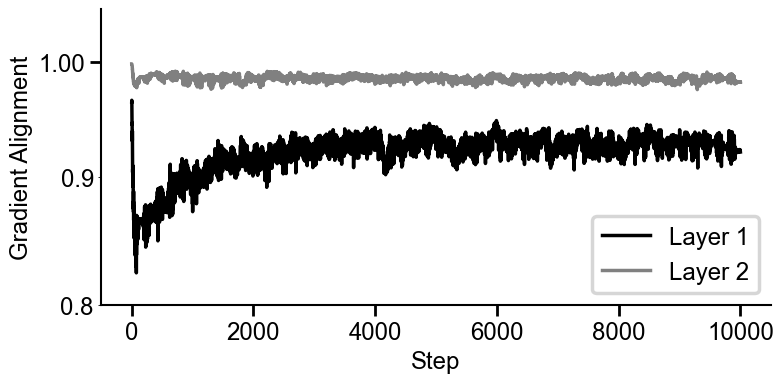

In [20]:
fig, ax = plt.subplots(figsize=(8, 4))
output_mu_fc0 = history_fc0_mean["gradient_alignment_fc0"]
output_std_fc0 = history_fc0_std["gradient_alignment_fc0"]
ax.plot(output_mu_fc0, label="Layer 1", color='black')
# ax.fill_between(range(len(output_mu_fc0)), output_mu_fc0 - output_std_fc0, output_mu_fc0 + output_std_fc0, alpha=0.2, color='red')
output_mu_fc1 = history_fc1_mean["gradient_alignment_fc1"]
output_std_fc1 = history_fc1_std["gradient_alignment_fc1"]
ax.plot(output_mu_fc1, label="Layer 2", color='gray')
# ax.fill_between(range(len(output_mu_fc1)), output_mu_fc1 - output_std_fc1, output_mu_fc1 + output_std_fc1, alpha=0.2, color='black')
ax.set_xlabel("Step")
ax.set_ylabel("Gradient Alignment")
ax.set_yscale('log')
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_minor_formatter(ScalarFormatter())
ax.set_ylim(0.8,1.05)
ax.legend()
# ax.grid(True)

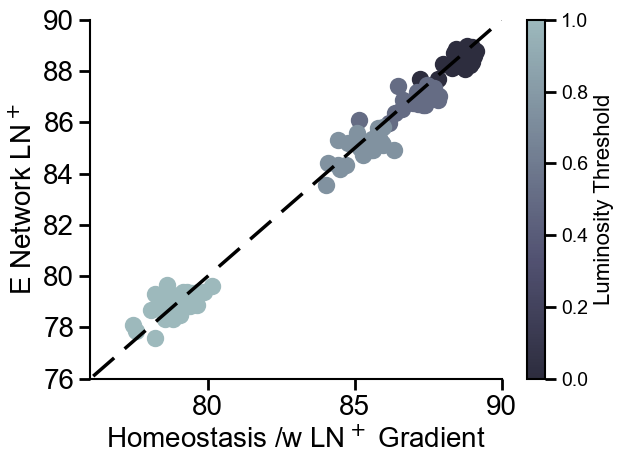

In [30]:
fig, ax = plt.subplots()

# Example brightness factors used
brightness_values = [0, 0.5, 0.75, 1]

# Normalize brightness for colormap mapping
norm = mcolors.Normalize(vmin=min(brightness_values), vmax=max(brightness_values))

def truncate_colormap(cmap, minval=0.2, maxval=1.0, n=256):
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        f'trunc({cmap.name},{minval:.2f},{maxval:.2f})',
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

# Create a grayscale colormap from 20% (dark gray) to 100% (black)
cmap = truncate_colormap(plt.get_cmap('bone'), 0.2, 0.7)

scatter_handles = []  # For legend proxy if needed

list_line = range(100)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.plot(list_line, list_line, label='y = x', color='black', linestyle='--')
ax.set_xlabel(f"Homeostasis /w LN$^+$ Gradient", fontsize=20)
ax.set_ylabel("E Network LN$^+$", fontsize=20)

for bfi in brightness_values:
    color = cmap(norm(bfi))

    runs_dict = dict()

    runs_dict["runs_vanilla_dann_layernorm"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_LNHomeostasis', filters={"config.dataset": "fashionmnist", 
                                                            "config.brightness_factor": bfi, "config.homeostasis": 0, "config.normtype": 0, "config.normtype_detach": 0,
                                                            "config.excitation_training": 1, "config.layer_norm": 1, "config.use_testset": True}, order="-summary_metrics.test_acc")
    runs_dict["runs_homeostasis"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_LNHomeostasis', filters={"config.dataset": "fashionmnist", 
                                                            "config.brightness_factor": bfi, "config.homeostasis": 1, "config.normtype": 0, "config.normtype_detach": 0,
                                                            "config.excitation_training": 1, "config.layer_norm": None, "config.feedback_alignment":0, "config.use_testset": True}, order="-summary_metrics.test_acc")

    top_n = len(runs_dict["runs_vanilla_dann_layernorm"])

    for top in range(top_n):
        vanilla_dann_acc = runs_dict["runs_vanilla_dann_layernorm"][top].summary['test_acc']
        for rn in runs_dict["runs_homeostasis"]:
            if same_config(rn.config, runs_dict["runs_vanilla_dann_layernorm"][top].config, keys=['lr', 'wd','inhib_lrs', 'momentum', 'inhib_momentum']):
                sc = ax.scatter(rn.summary['test_acc'], vanilla_dann_acc, color=color)
                break  # Only label once per brightness group
ax.set_xlim(76, 90)
ax.set_ylim(76, 90)

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Luminosity Threshold', fontsize=16)
cbar.ax.tick_params(labelsize=14)
plt.savefig("figure4b.svg", format="svg")